In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-01-14 18:00:03.614411: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 18:00:03.631330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736877603.650543     212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736877603.656602     212 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 18:00:03.676356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("goubeast/age-prediction-av")

print("Path to dataset files:", path)

100%|██████████| 64.7M/64.7M [00:00<00:00, 80.3MB/s]

Extracting files...


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/goubeast/age-prediction-av/versions/1


In [5]:
! ls data/train/old


10019.jpg  13515.jpg  17028.jpg  20323.jpg  23707.jpg  3335.jpg  6651.jpg
10040.jpg  13520.jpg  17030.jpg  20407.jpg  23711.jpg  3338.jpg  6685.jpg
10055.jpg  1352.jpg   17037.jpg  20415.jpg  23716.jpg  3344.jpg  6691.jpg
10059.jpg  13535.jpg  17042.jpg  20422.jpg  23717.jpg  3375.jpg  6693.jpg
10063.jpg  13537.jpg  17093.jpg  20431.jpg  23720.jpg  337.jpg	 6696.jpg
10093.jpg  13546.jpg  17095.jpg  20438.jpg  23766.jpg  3386.jpg  6713.jpg
10105.jpg  13558.jpg  17127.jpg  20488.jpg  23781.jpg  3401.jpg  6724.jpg
10116.jpg  13578.jpg  17137.jpg  2051.jpg   23785.jpg  3414.jpg  6732.jpg
10120.jpg  13604.jpg  17142.jpg  20523.jpg  23793.jpg  3421.jpg  6746.jpg
10122.jpg  13622.jpg  17218.jpg  20559.jpg  23824.jpg  342.jpg	 6811.jpg
1013.jpg   13652.jpg  17223.jpg  20569.jpg  23891.jpg  3435.jpg  6880.jpg
10147.jpg  13687.jpg  17227.jpg  2062.jpg   23917.jpg  3436.jpg  6888.jpg
10157.jpg  136.jpg    1722.jpg	 20648.jpg  23921.jpg  3462.jpg  6897.jpg
10168.jpg  13701.jpg  17261.jpg  20656.jp

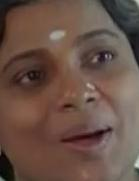

In [6]:
path = './data/train/old'
#name = '82.headshot.jpg'
name = '10019.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [7]:
img = load_img(fullname, target_size=(200, 200))
x = np.array(img)
x.shape

(200, 200, 3)

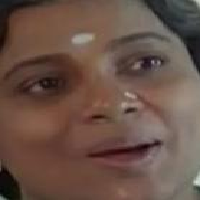

In [8]:
img

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1736877659.279335     212 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [10]:
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 313632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    20,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,073,473 (76.57 MB)

 Trainable params: 20,073,473 (76.57 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
train_dir = 'data/train'
test_dir = 'data/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6827 images belonging to 2 classes.


In [14]:
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2275 images belonging to 2 classes.


In [15]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [16]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1736877661.323141    3490 service.cc:148] XLA service 0x7f321c016aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736877661.323180    3490 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-14 18:01:01.343601: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736877661.422583    3490 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-14 18:01:01.705867: I external/local_xla/xla/servi

  5/342 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - acc: 0.5840 - loss: 0.6562

I0000 00:00:1736877662.843925    3490 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/342 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.7513 - loss: 0.5109

2025-01-14 18:01:11.671880: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,32,198,198]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,200,200]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.7551 - loss: 0.5023

2025-01-14 18:01:15.131194: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,198,198]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,200,200]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-14 18:01:18.663526: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,32,198,198]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,200,200]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_c

342/342 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - acc: 0.7551 - loss: 0.5022 - val_acc: 0.7886 - val_loss: 0.4525
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - acc: 0.8092 - loss: 0.4160 - val_acc: 0.7965 - val_loss: 0.4337
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.8211 - loss: 0.3959 - val_acc: 0.8224 - val_loss: 0.3954
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.8332 - loss: 0.3738 - val_acc: 0.8299 - val_loss: 0.3834
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.8277 - loss: 0.3855 - val_acc: 0.8286 - val_loss: 0.3798
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.8429 - loss: 0.3681 - val_acc: 0.8277 - val_loss: 0.3810
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.8572 - loss: 0.3316 - val_acc: 0.8374 - val_loss: 0.3793
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - acc: 0.8578 - loss: 0.3362 - val_acc: 0.8422 - val_loss: 0.3585
Epoch 9/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - ac

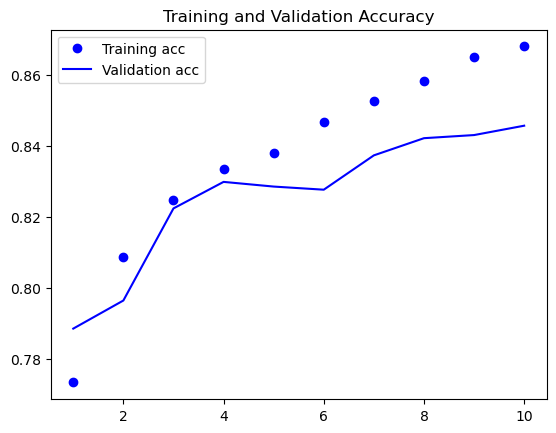

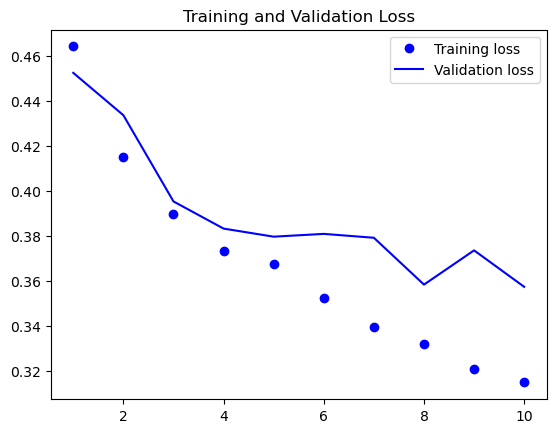

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
acc_median = np.median(acc)
acc_median

np.float64(0.8423172533512115)

In [19]:
loss_std = np.std(loss)
loss_std

np.float64(0.04392361509534359)

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6827 images belonging to 2 classes.


In [23]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2275 images belonging to 2 classes.


In [24]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - acc: 0.8050 - loss: 0.4247

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


342/342 ━━━━━━━━━━━━━━━━━━━━ 57s 167ms/step - acc: 0.8050 - loss: 0.4247 - val_acc: 0.8171 - val_loss: 0.4090
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 60s 174ms/step - acc: 0.8003 - loss: 0.4265 - val_acc: 0.8374 - val_loss: 0.3682
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - acc: 0.8211 - loss: 0.3952 - val_acc: 0.8426 - val_loss: 0.3596
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - acc: 0.8187 - loss: 0.3991 - val_acc: 0.8440 - val_loss: 0.3497
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 55s 161ms/step - acc: 0.8142 - loss: 0.4015 - val_acc: 0.8409 - val_loss: 0.3586
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 57s 168ms/step - acc: 0.8273 - loss: 0.3887 - val_acc: 0.8391 - val_loss: 0.3668
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 56s 164ms/step - acc: 0.8162 - loss: 0.3911 - val_acc: 0.8382 - val_loss: 0.3605
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 57s 166ms/step - acc: 0.8210 - loss: 0.3890 - val_acc: 0.8545 - val_loss: 0.3418
Epoch 9/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 56s

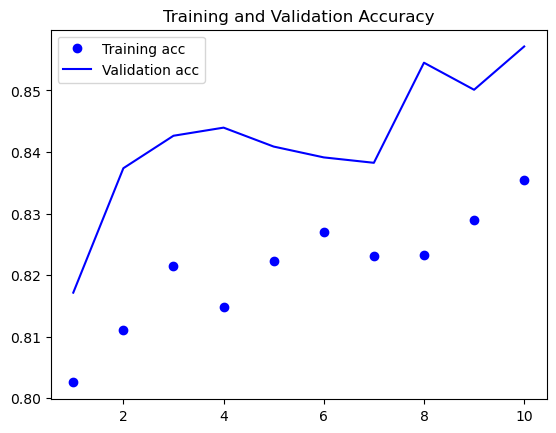

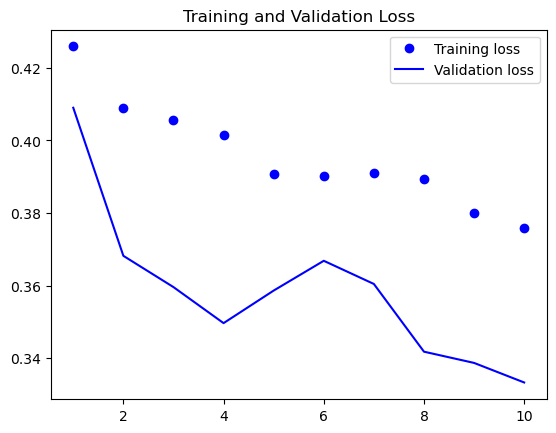

In [25]:
acc_aug = history.history['acc']
val_acc_aug = history.history['val_acc']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [26]:
loss_mean_aug = np.mean(val_loss_aug)
loss_mean_aug

np.float64(0.35862394571304324)

In [27]:
val_acc_aug[5:10]

[0.8391208648681641,
 0.8382417559623718,
 0.8545054793357849,
 0.850109875202179,
 0.8571428656578064]

In [28]:
acc_mean_aug = np.mean(val_acc_aug[5:10])
acc_mean_aug

np.float64(0.8478241682052612)